In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib

sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

# Load raw events

In [3]:
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

# bkg = read_h5_file(database_path, files["SM"])
# # SM processes

# neutral_boson = read_h5_file(database_path, files["neutral_boson"])
# print(neutral_boson.shape)
# # A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

# leptoquark = read_h5_file(database_path, files["leptoquark"])
# print(leptoquark.shape)
# # A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

# neutral_Higgs = read_h5_file(database_path, files["neutral_Higgs"])
# print(neutral_Higgs.shape)
# # A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

# charged_Higgs = read_h5_file(database_path, files["charged_Higgs"])
# print(charged_Higgs.shape)
# # A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino

events = {}
for key, value in files.items():
    events[key] = read_h5_file(database_path, value)
    print(key, events[key].shape)

SM (13451915, 19, 4)
neutral_boson (55969, 19, 4)
leptoquark (340544, 19, 4)
neutral_Higgs (691283, 19, 4)
charged_Higgs (760272, 19, 4)


In [4]:
signals = [key for key in events.keys() if key != "SM"]
print(signals)

['neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs']


# Load embedding model

In [5]:
model_hyper_parameters = load_toml_config("Transformer")
print(model_hyper_parameters)
feature_size = model_hyper_parameters["feature_size"]
embed_size = model_hyper_parameters["embed_size"]
num_heads = model_hyper_parameters["num_heads"]
num_layers = model_hyper_parameters["num_layers"]
hidden_dim = model_hyper_parameters["hidden_dim"]
output_dim = model_hyper_parameters["output_dim"]

embedding_model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)
model_name = "emb_dim{}_type_scale{}.pt".format(output_dim, particle_type_scale) if EMD_config['pid_method'] == 'one-hot' else "emb_dim{}_sep.pt".format(output_dim)
embedding_model.load_state_dict(torch.load(os.path.join("..", "model", model_name)))
embedding_model.to(device)

{'feature_size': 3, 'embed_size': 16, 'num_heads': 8, 'num_layers': 4, 'hidden_dim': 256, 'output_dim': 4}


/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ParticleEventTransformer(
  (particle_embedding): Linear(in_features=3, out_features=16, bias=True)
  (pos_encoder): ParticlePositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=304, out_features=4, bias=True)
)

# Embed events

In [6]:
from analysis import inference

In [7]:
from data import EventDataset

In [8]:
infer_test_num = 1000000
dataloaders = {}
for key, value in events.items():
    dataloaders[key] = DataLoader(EventDataset(value[:infer_test_num]), batch_size=256, num_workers=16, prefetch_factor=5)

In [9]:
embedding_points = {}

for key, value in dataloaders.items():
    embedding_points[key] = inference(embedding_model, value, embed_dim=output_dim)
    print(key, embedding_points[key].shape)

100%|██████████| 3907/3907 [00:08<00:00, 444.49it/s]


SM (1000000, 4)


100%|██████████| 219/219 [00:01<00:00, 205.75it/s]


neutral_boson (55969, 4)


100%|██████████| 1331/1331 [00:03<00:00, 406.80it/s]


leptoquark (340544, 4)


100%|██████████| 2701/2701 [00:06<00:00, 443.52it/s]


neutral_Higgs (691283, 4)


100%|██████████| 2970/2970 [00:06<00:00, 442.12it/s]

charged_Higgs (760272, 4)


In [10]:
from analysis import Normalizer

In [11]:
normalizer = Normalizer(*[value for value in embedding_points.values()])

In [12]:
print(normalizer.max)
print(normalizer.min)

[364.83032227 370.31808472 327.48770142 325.64743042]
[-377.18408203 -350.75219727 -309.62716675 -340.06167603]


# Split embed points

In [13]:
tpr_dict = {}
fpr_dict = {}
auc_dict = {}

In [14]:
from analysis import create_exp_bkg_events, train_test_split, get_dataloaders

In [124]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 100000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"

exp_events, bkg_events = create_exp_bkg_events(embedding_points['SM'], embedding_points[test_signal], sig_lambda, n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

# Classify Model

In [125]:
from model import MLP
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

# Train

In [126]:
from metrics import BinaryACCUpdater

In [127]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [128]:
from classify import train_model

In [129]:
# opt_train_model  = torch.compile(train_model)

In [130]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-06-16 22:59:55
Epoch 1 / 50

100%|██████████| 125/125 [00:00<00:00, 730.04it/s, val_Accuracy=0.584, val_loss=0.665]
<<<<<< reach best val_Accuracy : 0.5841562747955322 >>>>>>

================================================================================2024-06-16 22:59:59
Epoch 2 / 50

100%|██████████| 125/125 [00:00<00:00, 688.20it/s, val_Accuracy=0.586, val_loss=0.663]
<<<<<< reach best val_Accuracy : 0.5858438014984131 >>>>>>

================================================================================2024-06-16 23:00:04
Epoch 3 / 50

100%|██████████| 125/125 [00:00<00:00, 689.59it/s, val_Accuracy=0.586, val_loss=0.663]

================================================================================2024-06-16 23:00:09
Epoch 4 / 50

100%|██████████| 125/125 [00:00<00:00, 694.88it/s, val_Accuracy=0.586, val_loss=0.663]
<<<<<< reach best val_Accuracy : 0.5863749980926514 >>>>>>

==============

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.668589,0.575766,0.664601,0.584156,1
1,0.665204,0.581711,0.663214,0.585844,2
2,0.664904,0.583016,0.663057,0.585688,3
3,0.664625,0.582297,0.662853,0.586375,4
4,0.664634,0.583602,0.663689,0.583375,5
5,0.664527,0.583008,0.662762,0.586844,6
6,0.664370,0.583398,0.662658,0.584500,7
7,0.663612,0.583055,0.661674,0.585750,8
8,0.663022,0.584055,0.659714,0.586875,9
9,0.661158,0.585305,0.658104,0.587375,10


# ROC

In [22]:
from analysis import predict

In [23]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 125/125 [00:00<00:00, 1063.40it/s]


0.718566509765625


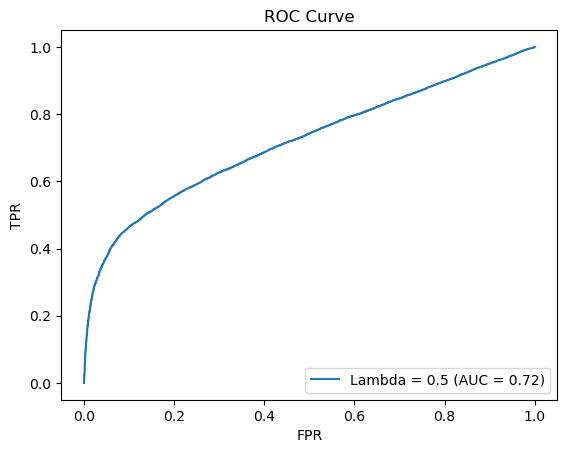

In [24]:
from analysis import calculate_auc
from visualize import plot_roc_curve
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
print(auc_roc)
fpr_dict[str(sig_lambda)] = fpr
tpr_dict[str(sig_lambda)] = tpr
auc_dict[str(sig_lambda)] = auc_roc
plot_roc_curve(fpr_dict, tpr_dict, auc_dict, "ROC Curve")

# Test statistics

In [25]:
import analysis
import importlib
importlib.reload(analysis)
from analysis import Bootstrap_Permutation

In [26]:
bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)

In [27]:
lrt_null_bootstarp, auc_null_bootstarp, mce_null_bootstarp = bootstrap_permutation.bootstrap(1000)

100%|██████████| 1000/1000 [00:43<00:00, 22.93it/s]


In [28]:
lrt_null_permutation, auc_null_permutation, mce_null_permutation = bootstrap_permutation.permutation(1000)

100%|██████████| 1000/1000 [00:43<00:00, 22.85it/s]


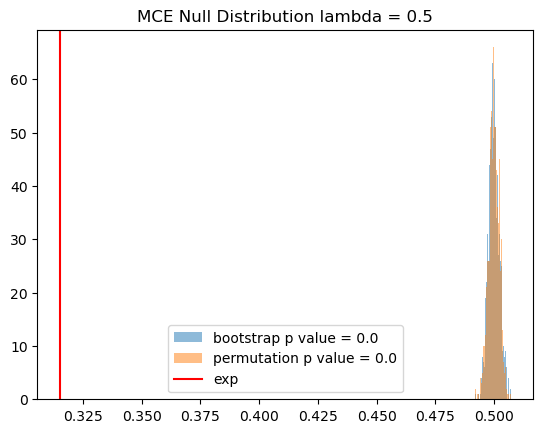

In [29]:
plt.hist(mce_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.mce_p_bootstrap))
plt.hist(mce_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.mce_p_permutation))
plt.axvline(bootstrap_permutation.mce_exp, color='r', label="exp")
plt.legend()
plt.title("MCE Null Distribution lambda = {}".format(sig_lambda))
plt.show()

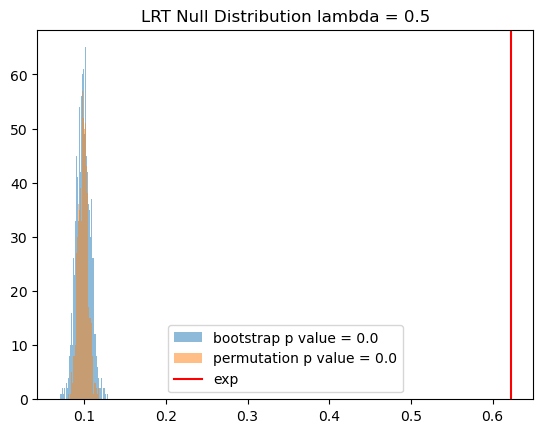

In [30]:
plt.hist(lrt_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.lrt_p_bootstrap))
plt.hist(lrt_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.lrt_p_permutation))
plt.axvline(bootstrap_permutation.lrt_exp, color='r', label="exp")
plt.legend()
plt.title("LRT Null Distribution lambda = {}".format(sig_lambda))
plt.show()

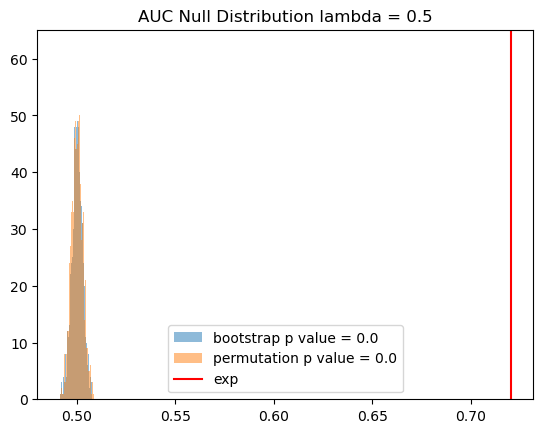

In [31]:
plt.hist(auc_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.auc_p_bootstrap))
plt.hist(auc_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.auc_p_permutation))
plt.axvline(bootstrap_permutation.auc_exp, color='r', label="exp")
plt.legend()
plt.title("AUC Null Distribution lambda = {}".format(sig_lambda))
plt.show()

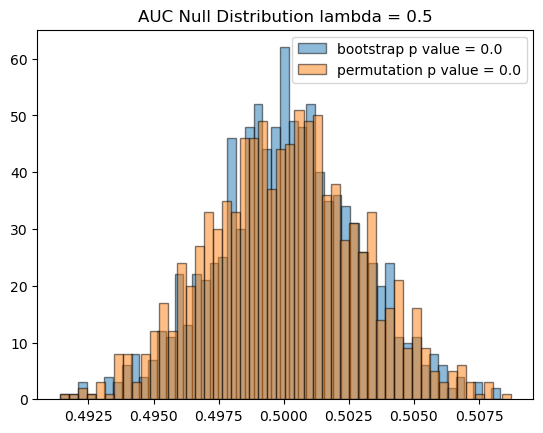

In [32]:
plt.hist(auc_null_bootstarp, bins=50, alpha=0.5,label="bootstrap p value = {}".format(bootstrap_permutation.auc_p_bootstrap), edgecolor='black')
plt.hist(auc_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.auc_p_permutation), edgecolor='black')
# plt.axvline(bootstrap_permutation.auc_exp, color='r', label="exp")
plt.legend()
plt.title("AUC Null Distribution lambda = {}".format(sig_lambda))
plt.show()

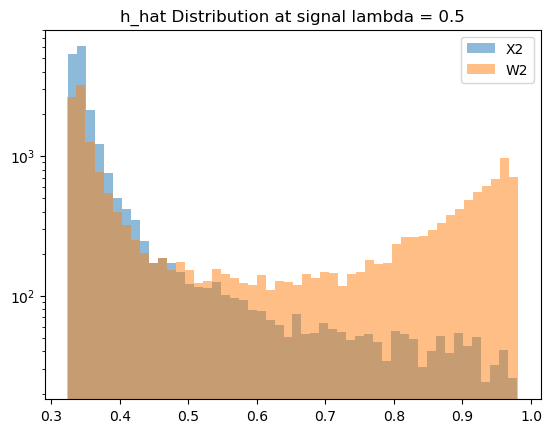

In [33]:
from analysis import h_hat
h_hat_X2 = h_hat(naive_model, X2, normalizer)
h_hat_W2 = h_hat(naive_model, W2, normalizer)
plt.hist(h_hat_X2, bins=50, alpha=0.5, label="X2")
plt.hist(h_hat_W2, bins=50, alpha=0.5, label="W2")
plt.yscale("log")
plt.legend()
plt.title("h_hat Distribution at signal lambda = {}".format(sig_lambda))
plt.show()

# Pure background null distribution

In [34]:
from analysis import create_exp_null

In [35]:
n = 100000
n_null = 1000

exp_events, bkg_events = create_exp_null(embedding_points['SM'], n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
n2 = len(W2)
m2 = len(X2)

In [36]:
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

hidden_dim = [8, 16, 16, 16, 8]
bkg_model = MLP(output_dim, hidden_sizes=hidden_dim)
bkg_model.to(device)
optimizer = torch.optim.Adam(bkg_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

train_model(
    bkg_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50,
    verbose=True
    )

bkg_null = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
lrt_bkg_bootstarp, auc_bkg_bootstarp, mce_bkg_bootstarp  = bkg_null.bootstrap(n_null, verbose=True)
lrt_bkg_permutation, auc_bkg_permutation, mce_bkg_permutation = bkg_null.permutation(n_null, verbose=True)


================================================================================2024-06-15 15:47:41
Epoch 1 / 50

100%|██████████| 125/125 [00:00<00:00, 674.86it/s, val_Accuracy=0.5, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5 >>>>>>

================================================================================2024-06-15 15:47:45
Epoch 2 / 50

100%|██████████| 125/125 [00:00<00:00, 705.34it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-06-15 15:47:49
Epoch 3 / 50

100%|██████████| 125/125 [00:00<00:00, 685.04it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-06-15 15:47:54
Epoch 4 / 50

100%|██████████| 125/125 [00:00<00:00, 681.74it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-06-15 15:47:58
Epoch 5 / 50

100%|██████████| 125/125 [00:00<00:00, 63

100%|██████████| 1000/1000 [00:43<00:00, 22.89it/s]


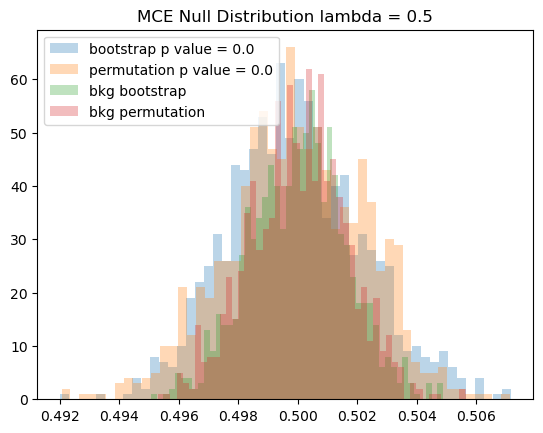

In [37]:
plt.hist(mce_null_bootstarp, bins=50, alpha=0.3, label="bootstrap p value = {}".format(bootstrap_permutation.mce_p_bootstrap))
plt.hist(mce_null_permutation, bins=50, alpha=0.3, label="permutation p value = {}".format(bootstrap_permutation.mce_p_permutation))
plt.hist(mce_bkg_bootstarp, bins=50, alpha=0.3, label="bkg bootstrap")
plt.hist(mce_bkg_permutation, bins=50, alpha=0.3, label="bkg permutation")
plt.legend()
plt.title("MCE Null Distribution lambda = {}".format(sig_lambda))
plt.show()

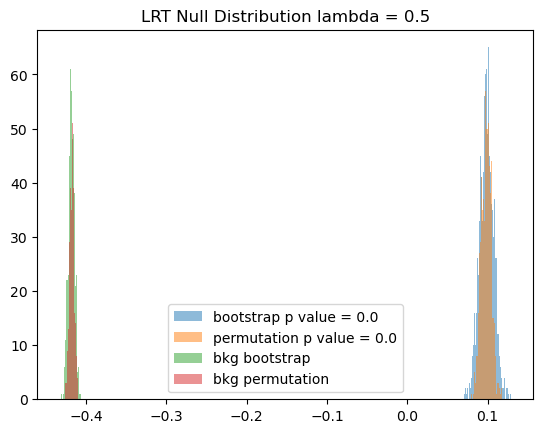

In [38]:
plt.hist(lrt_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.lrt_p_bootstrap))
plt.hist(lrt_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.lrt_p_permutation))
plt.hist(lrt_bkg_bootstarp, bins=50, alpha=0.5, label="bkg bootstrap")
plt.hist(lrt_bkg_permutation, bins=50, alpha=0.5, label="bkg permutation")
plt.legend()
plt.title("LRT Null Distribution lambda = {}".format(sig_lambda))
plt.show()

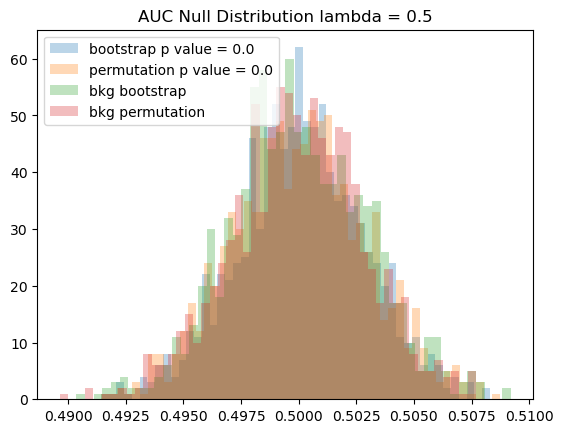

In [39]:
plt.hist(auc_null_bootstarp, bins=50, alpha=0.3, label="bootstrap p value = {}".format(bootstrap_permutation.auc_p_bootstrap))
plt.hist(auc_null_permutation, bins=50, alpha=0.3, label="permutation p value = {}".format(bootstrap_permutation.auc_p_permutation))
plt.hist(auc_bkg_bootstarp, bins=50, alpha=0.3, label="bkg bootstrap")
plt.hist(auc_bkg_permutation, bins=50, alpha=0.3, label="bkg permutation")
plt.legend()
plt.title("AUC Null Distribution lambda = {}".format(sig_lambda))
plt.show()

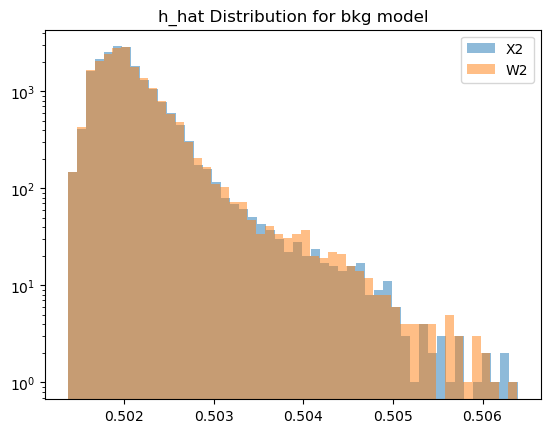

In [40]:
from analysis import h_hat
h_hat_X2 = h_hat(bkg_model, X2, normalizer)
h_hat_W2 = h_hat(bkg_model, W2, normalizer)
plt.hist(h_hat_X2, bins=50, alpha=0.5, label="X2")
plt.hist(h_hat_W2, bins=50, alpha=0.5, label="W2")
plt.yscale("log")
plt.legend()
plt.title("h_hat Distribution for bkg model")
plt.show()

# Estimate signal strength

In [41]:
from analysis import LambdaEstimator

estimated lambda: 0.019695269295948004
beta 0 = -0.01076339477402422, beta 1 = -0.009128411180320808
last bin height: 0.980304730704052


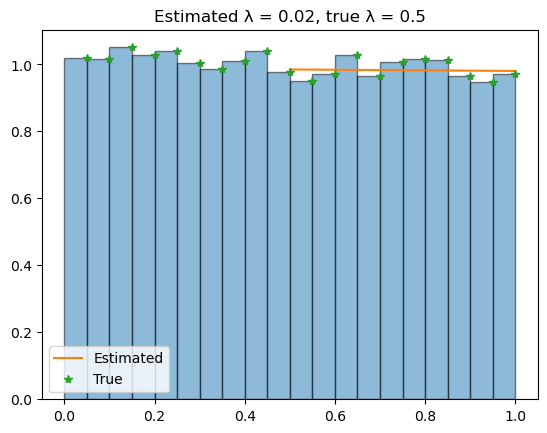

In [42]:
lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
print("estimated lambda:", lambda_estimator.estimated_lambda)
print("beta 0 = {}, beta 1 = {}".format(lambda_estimator.beta0, lambda_estimator.beta1))
print("last bin height:", lambda_estimator.estimated_H_t[-1])
plt.hist(lambda_estimator.rho_W, bins=lambda_estimator.bins, alpha=0.5, edgecolor='black', density=True)
start_idx = lambda_estimator.fit_start_idx
plt.plot(lambda_estimator.bins[start_idx:], lambda_estimator.estimated_H_t, label="Estimated")
plt.plot(lambda_estimator.bins[1:], lambda_estimator.H_t, '*',label="True")
plt.legend()
plt.title("Estimated λ = {:.2f}, true λ = {}".format(lambda_estimator.estimated_lambda, sig_lambda))
plt.show()

# Bootstrapped Uncertainty Intervals for λ

In [43]:
lambda_mean_dict = {}
lambda_std_dict = {}

lrt_p_permutation_dict = {}
lrt_p_bootstrap_dict = {}
auc_p_permutation_dict = {}
auc_p_bootstrap_dict = {}
mce_p_permutation_dict = {}
mce_p_bootstrap_dict = {}

In [44]:
import importlib
import classify
import analysis
importlib.reload(classify)
importlib.reload(analysis)
from classify import train_model
from analysis import Bootstrap_Permutation
opt_train_model  = torch.compile(train_model)

In [45]:
n_bootstrap = 10


test_ratio=0.2
val_ratio = 0.2
n = 10000
n_null = 1000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"
significance = 0.05


test_lambdas = [0.01, 0.02, 0.05, 0.1]
for i in tqdm(range(len(test_lambdas))):
    sig_lambda = test_lambdas[i]

    estimated_lambdas = np.zeros(n_bootstrap)

    lrt_permutation_power = 0
    lrt_bootstrap_power = 0
    auc_permutation_power = 0
    auc_bootstrap_power = 0
    mce_permutation_power = 0
    mce_bootstrap_power = 0
    for j in range(n_bootstrap):
        exp_events, bkg_events = create_exp_bkg_events(embedding_points['SM'], embedding_points[test_signal], sig_lambda, n)
        X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
        n1 = len(W1)
        m1 = len(X1)
        n2 = len(W2)
        m2 = len(X2)
        train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer)

        hidden_dim = [8, 16, 16, 16, 8]
        naive_model = MLP(output_dim, hidden_sizes=hidden_dim)
        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.BCELoss()
        acc_metric = BinaryACCUpdater()
        metric_dict = {"Accuracy": acc_metric}

        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
            )
        
        bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
        _, _, _ = bootstrap_permutation.bootstrap(n_null, verbose=False)
        _, _, _ = bootstrap_permutation.permutation(n_null, verbose=False)
        if bootstrap_permutation.lrt_p_permutation < significance:
            lrt_permutation_power += 1
        if bootstrap_permutation.lrt_p_bootstrap < significance:
            lrt_bootstrap_power += 1
        if bootstrap_permutation.auc_p_permutation < significance:
            auc_permutation_power += 1
        if bootstrap_permutation.auc_p_bootstrap < significance:
            auc_bootstrap_power += 1
        if bootstrap_permutation.mce_p_permutation < significance:
            mce_permutation_power += 1
        if bootstrap_permutation.mce_p_bootstrap < significance:
            mce_bootstrap_power += 1

        lambda_estimator = LambdaEstimator(X2, W2, naive_model, T=0.5, n_bins=20, normalizer=normalizer)
        estimated_lambdas[j] = lambda_estimator.estimated_lambda
    print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
    lambda_mean_dict[str(sig_lambda)] = estimated_lambdas.mean()
    lambda_std_dict[str(sig_lambda)] = estimated_lambdas.std(ddof = 1)
    lrt_p_permutation_dict[str(sig_lambda)] = lrt_permutation_power
    lrt_p_bootstrap_dict[str(sig_lambda)] = lrt_bootstrap_power
    auc_p_permutation_dict[str(sig_lambda)] = auc_permutation_power
    auc_p_bootstrap_dict[str(sig_lambda)] = auc_bootstrap_power
    mce_p_permutation_dict[str(sig_lambda)] = mce_permutation_power
    mce_p_bootstrap_dict[str(sig_lambda)] = mce_bootstrap_power


<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>


<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
sig_lambda: 0.01 estimated lambda mean: 0.02952081653161085 estimated lambda std: 0.04008548116762338
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val

In [46]:
print(estimated_lambdas)
print(lambda_mean_dict)
print(lambda_std_dict)

[0.03636364 0.17705877 0.02454545 0.01819518 0.06818182 0.01
 0.00043023 0.05545455 0.00909091 0.11656519]
{'0.01': 0.02952081653161085, '0.02': 0.038247175883973285, '0.05': 0.03496976376459088, '0.1': 0.05158857302288694}
{'0.01': 0.04225380719782523, '0.02': 0.044007027001878626, '0.05': 0.04005892168981014, '0.1': 0.0562594149469426}


In [47]:
import visualize
importlib.reload(visualize)
from visualize import plot_lambda

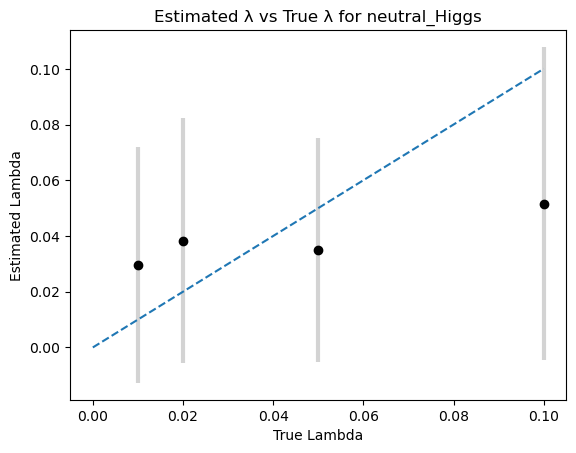

In [48]:
plot_lambda(lambda_mean_dict, lambda_std_dict, test_signal)

In [49]:
print(lrt_p_permutation_dict)
print(lrt_p_bootstrap_dict)
print(auc_p_permutation_dict)
print(auc_p_bootstrap_dict)
print(mce_p_permutation_dict)
print(mce_p_bootstrap_dict)

{'0.01': 2, '0.02': 1, '0.05': 6, '0.1': 9}
{'0.01': 0, '0.02': 0, '0.05': 2, '0.1': 9}
{'0.01': 1, '0.02': 0, '0.05': 3, '0.1': 4}
{'0.01': 1, '0.02': 0, '0.05': 3, '0.1': 5}
{'0.01': 5, '0.02': 7, '0.05': 5, '0.1': 5}
{'0.01': 4, '0.02': 6, '0.05': 3, '0.1': 5}


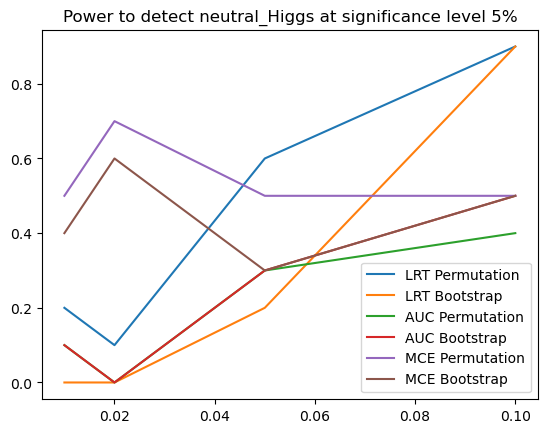

In [50]:
plt.plot(test_lambdas, np.array([lrt_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="LRT Permutation")
plt.plot(test_lambdas, np.array([lrt_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="LRT Bootstrap")
plt.plot(test_lambdas, np.array([auc_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="AUC Permutation")
plt.plot(test_lambdas, np.array([auc_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="AUC Bootstrap")
plt.plot(test_lambdas, np.array([mce_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="MCE Permutation")
plt.plot(test_lambdas, np.array([mce_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="MCE Bootstrap")
plt.title("Power to detect {} at significance level {:.0%}".format(test_signal, significance))
plt.legend()
plt.show()

In [51]:
import pandas as pd
power_df = pd.DataFrame(columns=test_lambdas)
power_df.loc["LRT Permutation"] = [lrt_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["LRT Bootstrap"] = [lrt_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Permutation"] = [auc_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Bootstrap"] = [auc_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Permutation"] = [mce_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Bootstrap"] = [mce_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]

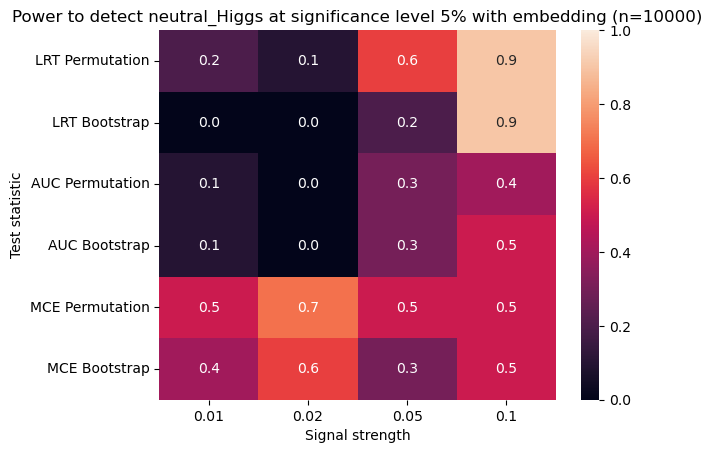

In [52]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(power_df, annot=True, fmt=".1f", vmin=0, vmax=1)

ax.set_title("Power to detect {} at significance level {:.0%} with embedding (n={})".format(test_signal, significance, n))
plt.xlabel("Signal strength")
plt.ylabel("Test statistic")
plt.show()

In [53]:
h5file_name = "mlp_lambda_estimator_{}.h5".format(test_signal)
with pd.HDFStore(h5file_name) as store:
    store["power_df"] = power_df
    store["lambda_mean_dict"] = pd.Series(lambda_mean_dict)
    store["lambda_std_dict"] = pd.Series(lambda_std_dict)

# Interpreting the Classifier

In [131]:
from analysis import h_hat
import seaborn as sns

In [132]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 125/125 [00:00<00:00, 976.88it/s]


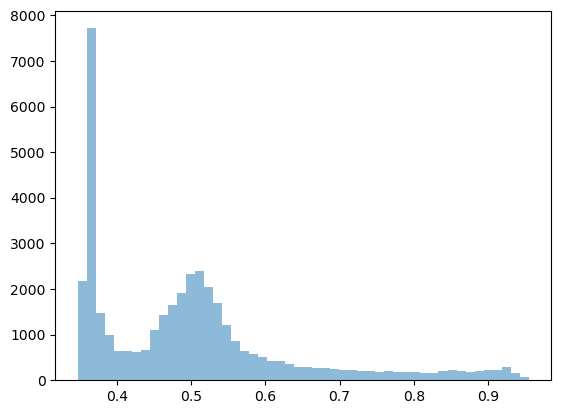

In [133]:
X2_W2 = np.concatenate((X2, W2))
h_hat_X2_W2 = h_hat(naive_model, X2_W2, normalizer)
plt.hist(h_hat_X2_W2, bins=50, alpha=0.5, label="X2")
plt.show()

In [134]:
bkg_index = h_hat_X2_W2 < 0.5
exp_index = h_hat_X2_W2 >= 0.5

In [135]:
from utils import embed_dict
sig_color = load_toml_config("sig_color")
bkg_dict = embed_dict(X2_W2[bkg_index], "SM")
exp_dict = embed_dict(X2_W2[exp_index], test_signal)
bkg_df = pd.DataFrame(bkg_dict)
exp_df = pd.DataFrame(exp_dict)
df = pd.concat([bkg_df, exp_df])

In [136]:
df

,type,Dimension 1,Dimension 2,Dimension 3,Dimension 4
0,SM,165.051651,-216.130646,-158.732086,172.506134
1,SM,252.171295,-176.657074,-192.473267,156.381424
2,SM,204.834244,-223.979370,-159.680405,190.799255
3,SM,212.092209,-228.334976,-153.379791,186.946198
4,SM,193.345840,-243.319672,-200.158432,162.038925
...,...,...,...,...,...
17656,neutral_Higgs,78.402679,-114.643799,71.189865,161.975159
17657,neutral_Higgs,183.925751,-82.965836,-83.755936,22.693949
17658,neutral_Higgs,206.059250,-117.312256,-158.006531,69.329239
17659,neutral_Higgs,129.445129,2.807575,69.525246,14.113441


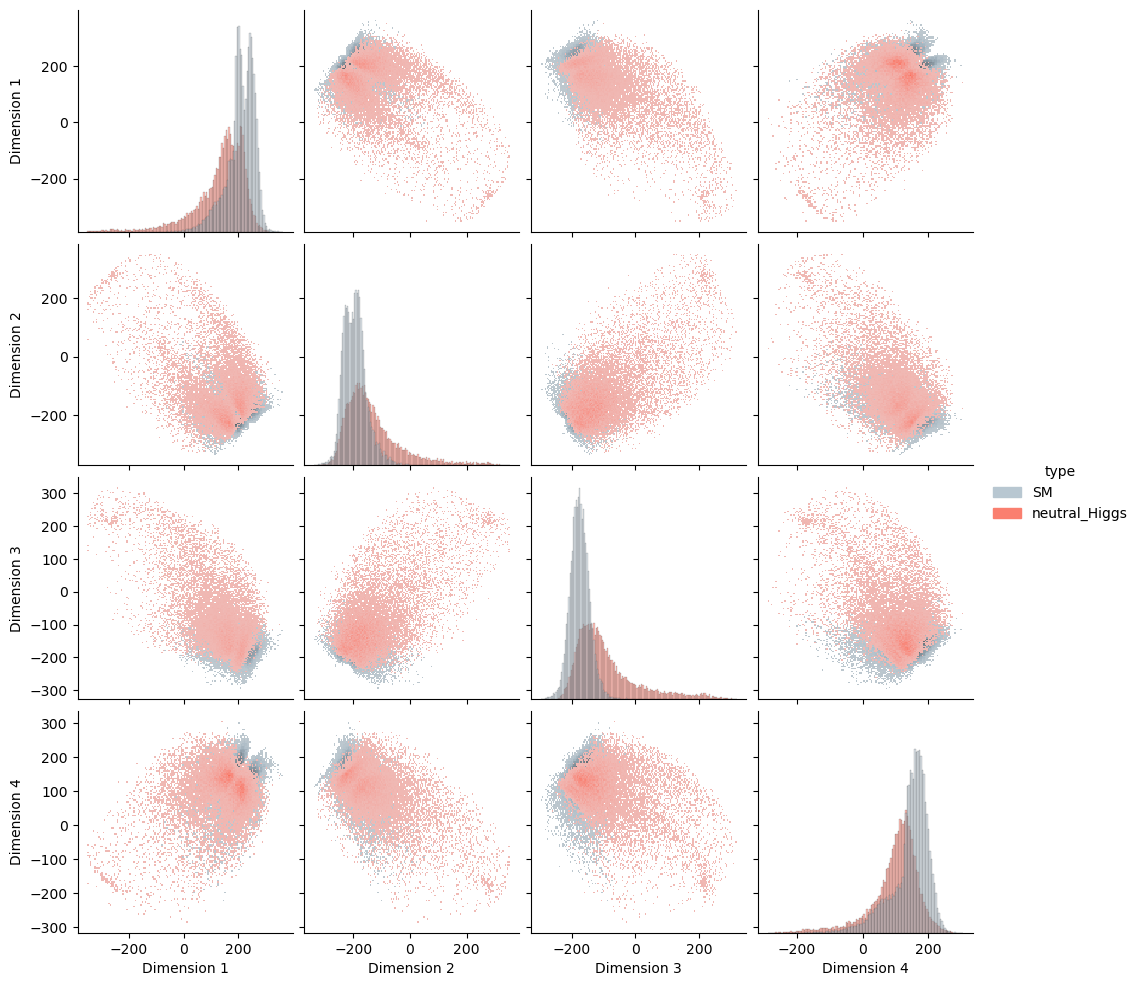

In [137]:
sns.pairplot(df, hue="type", kind="hist", palette=sig_color)
plt.show()

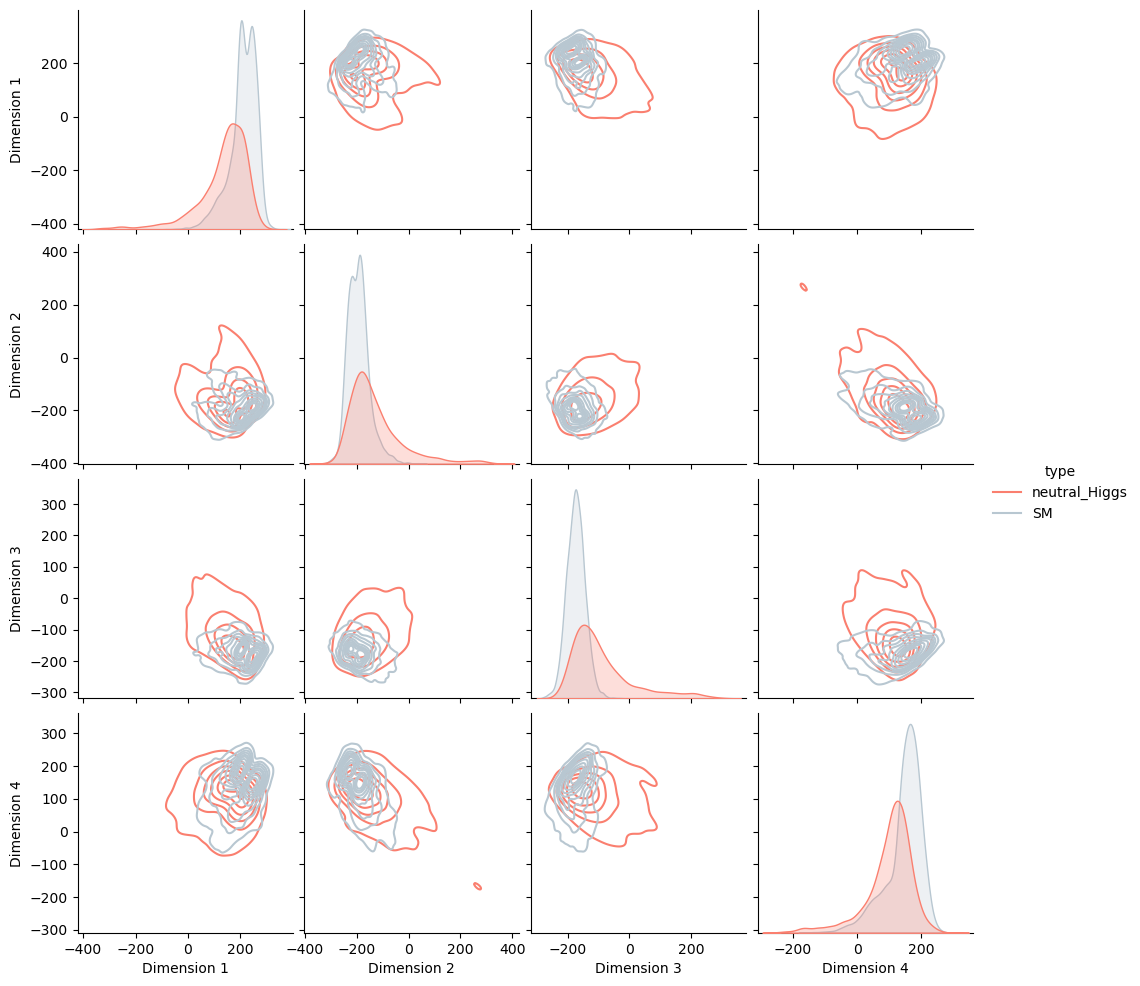

In [138]:
from visualize import downsample_and_visualize_pairplot
downsample_and_visualize_pairplot(df, 10000, sig_color)

In [139]:
def logit(h):
    return np.log(h / (1 - h))

In [140]:
H_predictions = logit(predictions)

In [141]:
print(H_predictions.max(), H_predictions.min()) 
print(H_predictions.shape)
print(predictions.shape)

3.104259060698414 -0.6278033788702192
(32000,)
(32000,)


In [142]:
X1[0]

array([ 206.94348145, -226.58529663, -156.35189819,  192.46748352])

In [143]:
input_vector = torch.tensor(normalizer(X1[0]), requires_grad=True).float().to(device)
input_vector.retain_grad()  # Non-leaf tensor requires grad

output = naive_model(input_vector)
print(output)

output.backward()

input_grad = input_vector.grad

print("Input Vector Gradient: ", input_grad)

tensor([0.3628], device='cuda:0', grad_fn=<ViewBackward0>)
Input Vector Gradient:  tensor([-0.4733,  0.3140,  0.2160, -0.1424], device='cuda:0')


In [144]:
def gradient(input_vector, model, normalizer):
    input_vector = torch.tensor(normalizer(input_vector), requires_grad=True).float().to(device)
    input_vector.retain_grad()  # Non-leaf tensor requires grad

    output = model(input_vector)
    logit = torch.log(output / (1 - output))
    logit.backward()

    input_grad = input_vector.grad

    return input_grad.to("cpu").detach().numpy()

In [145]:
gradient(X1[3], naive_model, normalizer)

array([0.5332562, 1.187391 , 1.2549163, 0.2671169], dtype=float32)

In [146]:
def estimate_gradient(X, model, normalizer):
    gradients = []
    for i in range(len(X)):
        gradients.append(gradient(X[i], model, normalizer))
    return np.array(gradients)

In [147]:
beta_x2 = estimate_gradient(X2, naive_model, normalizer)
beta_w2 = estimate_gradient(W2, naive_model, normalizer)
print(beta_x2.shape, beta_w2.shape)
beta_composed = np.concatenate([beta_x2, beta_w2], axis=0)
print(beta_composed.shape)

(20000, 4) (20000, 4)
(40000, 4)


In [148]:
output_dict = {"type": [test_signal] * len(beta_composed)}
for i in range(beta_composed.shape[1]):
    output_dict["Gradient on dimension {}".format(i+1)] = beta_composed[:, i]

In [149]:
gradient_df = pd.DataFrame(output_dict)

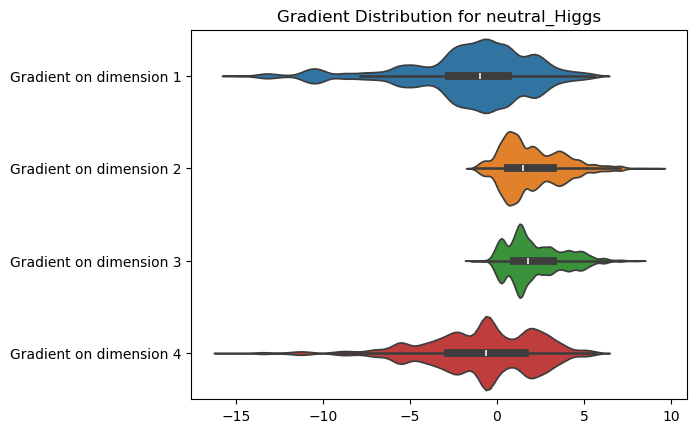

In [150]:
sns.violinplot(gradient_df, orient='h')
plt.title("Gradient Distribution for {}".format(test_signal))
plt.show()

In [151]:
standardized_beta = beta_composed / beta_composed.std(axis=0, ddof=1)
beta_mean = standardized_beta.mean(axis=0)
convariance_matrix = np.cov(standardized_beta.T, ddof=1)

In [152]:
print(convariance_matrix.shape)

(4, 4)


In [153]:
print(convariance_matrix)

[[ 1.00001084e+00 -1.81921354e-01  2.03552744e-05  7.30617255e-01]
 [-1.81921354e-01  1.00005005e+00  6.08797663e-01 -4.95428230e-01]
 [ 2.03552744e-05  6.08797663e-01  9.99987989e-01  1.35019525e-01]
 [ 7.30617255e-01 -4.95428230e-01  1.35019525e-01  1.00003680e+00]]


In [154]:
from sklearn.decomposition import PCA

In [155]:
pca = PCA(n_components=None)
pca.fit(convariance_matrix)
print('保留的主成分个数：' ,pca.n_components_)
print('保留的特征向量：\n',pca.components_)
print('保留的n个主成分各自方差：\n',pca.explained_variance_)

print('保留的n个主成分对原始数据信息累计解释的贡献率：\n',np.cumsum(pca.explained_variance_ratio_))

保留的主成分个数： 4
保留的特征向量：
 [[-0.47491608  0.59245062  0.33152647 -0.55995284]
 [-0.32173014 -0.22719645  0.77632881  0.49212303]
 [-0.78516108 -0.45168123 -0.4193734  -0.06026685]
 [ 0.23338063 -0.62719064  0.33396068 -0.66380392]]
保留的n个主成分各自方差：
 [1.33534633e+00 9.89391409e-02 1.78502684e-02 2.20447398e-34]
保留的n个主成分对原始数据信息累计解释的贡献率：
 [0.91957404 0.98770758 1.         1.        ]


In [156]:
h5file_name = "gradient_{}.h5".format(test_signal)
with pd.HDFStore(h5file_name) as store:
    store["gradient"] = gradient_df
    store["covariance_matrix"] = pd.DataFrame(convariance_matrix)